In [ ]:
%config InlineBackend.figure_formats = ['svg']
import os

STATIC_WEB_PAGE = {"EXECUTE_NB", "READTHEDOCS"}.intersection(os.environ)

```{autolink-concat}
```

````{margin}
```{spec} Spin alignment with data
:id: TR-013
:status: WIP
:tags: physics
:links: TR-014; TR-015
```
````

# Spin alignment with data

<!-- cspell:ignore phasespace -->
```{autolink-skip}
```

In [ ]:
%pip install -q ampform==0.13.0 qrules[viz]==0.9.7 tensorwaves[jax,pwa]==0.4.2

In this report, we attempt to check the effect of activating spin alignment ([ampform#245](https://github.com/ComPWA/ampform/pull/245)) and compare it with [Figure 2](https://downloads.hindawi.com/journals/ahep/2020/6674595.pdf#page=9)  in {cite}`marangottoHelicityAmplitudesGeneric2020`.

In [ ]:
import logging
import warnings

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

## Phase space sample

In [ ]:
import qrules

PDG = qrules.load_pdg()

In [ ]:
from tensorwaves.data import (
    TFPhaseSpaceGenerator,
    TFUniformRealNumberGenerator,
)

phsp_generator = TFPhaseSpaceGenerator(
    initial_state_mass=PDG["Lambda(c)+"].mass,
    final_state_masses={
        0: PDG["p"].mass,
        1: PDG["K-"].mass,
        2: PDG["pi+"].mass,
    },
)
rng = TFUniformRealNumberGenerator(seed=0)
phsp_momenta = phsp_generator.generate(1_000_000, rng)

## Generate transitions

In [ ]:
from qrules.particle import ParticleCollection, create_particle

particle_db = ParticleCollection()
particle_db.add(PDG["Lambda(c)+"])
particle_db.add(PDG["p"])
particle_db.add(PDG["K-"])
particle_db.add(PDG["pi+"])

particle_db.add(
    create_particle(
        PDG["K*(892)0"],
        name="K*",
        latex="K^*",
    )
)
particle_db.add(
    create_particle(
        PDG["Lambda(1405)"],
        name="Lambda*",
        latex=R"\Lambda^*",
    )
)
particle_db.add(
    create_particle(
        PDG["Delta(1232)++"],
        name="Delta*++",
        latex=R"\Delta^*",
    )
)

In [ ]:
reaction = qrules.generate_transitions(
    initial_state=("Lambda(c)+", [-0.5, +0.5]),
    final_state=["p", "K-", "pi+"],
    formalism="helicity",
    particle_db=particle_db,
)

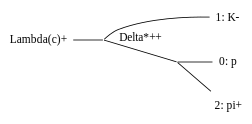

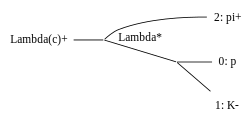

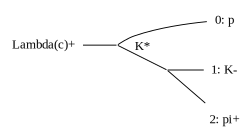

In [ ]:
import graphviz

n = len(reaction.transitions)
for t in reaction.transitions[:: n // 3]:
    dot = qrules.io.asdot([t], collapse_graphs=True, size=3.5)
    graph = graphviz.Source(dot)
    display(graph)

## Distribution without alignment

Amplitude model formulated following [Appendix C](https://downloads.hindawi.com/journals/ahep/2020/6674595.pdf#page=13):

In [ ]:
import ampform
from ampform.dynamics.builder import RelativisticBreitWignerBuilder

builder = ampform.get_builder(reaction)
builder.align_spin = False
builder.stable_final_state_ids = list(reaction.final_state)
builder.scalar_initial_state_mass = True
bw_builder = RelativisticBreitWignerBuilder()
for name in reaction.get_intermediate_particles().names:
    builder.set_dynamics(name, bw_builder)
standard_model = builder.formulate()
standard_model.intensity

PoolSum(Abs(A^01[m_A, m0, m1, m2] + A^02[m_A, m0, m1, m2] + A^12[m_A, m0, m1, m2])**2, (m_A, (1/2, -1/2)), (m0, (1/2, -1/2)), (m1, (0,)), (m2, (0,)))

In [ ]:
import sympy as sp
from IPython.display import Math, display

for i, (symbol, expr) in enumerate(standard_model.amplitudes.items()):
    if i == 3:
        display(Math(R"\dots"))
        break
    latex = sp.multiline_latex(symbol, expr, environment="eqnarray")
    display(Math(latex))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Importing the parameter values given by [Table 1](https://downloads.hindawi.com/journals/ahep/2020/6674595.pdf#page=13):

In [ ]:
from ampform.helicity import HelicityModel

# fmt: off
parameter_table = {
    # K*
    R"C_{\Lambda_{c}^{+} \to K^*_{0} p_{+1/2}; K^* \to K^{-}_{0} \pi^{+}_{0}}": 1,
    R"C_{\Lambda_{c}^{+} \to K^*_{+1} p_{+1/2}; K^* \to K^{-}_{0} \pi^{+}_{0}}": 0.5 + 0.5j,
    R"C_{\Lambda_{c}^{+} \to K^*_{-1} p_{-1/2}; K^* \to K^{-}_{0} \pi^{+}_{0}}": 1j,
    R"C_{\Lambda_{c}^{+} \to K^*_{0} p_{-1/2}; K^* \to K^{-}_{0} \pi^{+}_{0}}": -0.5 - 0.5j,
    "m_{K^*}": 0.9,  # GeV
    R"\Gamma_{K^*}": 0.2,  # GeV
    # Λ*
    R"C_{\Lambda_{c}^{+} \to \Lambda^*_{-1/2} \pi^{+}_{0}; \Lambda^* \to K^{-}_{0} p_{+1/2}}": 1j,
    R"C_{\Lambda_{c}^{+} \to \Lambda^*_{+1/2} \pi^{+}_{0}; \Lambda^* \to K^{-}_{0} p_{+1/2}}": 0.8 - 0.4j,
    R"m_{\Lambda^*}": 1.6,  # GeV
    R"\Gamma_{\Lambda^*}": 0.2,  # GeV
    # Δ*
    R"C_{\Lambda_{c}^{+} \to \Delta^*_{+1/2} K^{-}_{0}; \Delta^* \to p_{+1/2} \pi^{+}_{0}}": 0.6 - 0.4j,
    R"C_{\Lambda_{c}^{+} \to \Delta^*_{-1/2} K^{-}_{0}; \Delta^* \to p_{+1/2} \pi^{+}_{0}}": 0.1j,
    R"m_{\Delta^*}": 1.4,  # GeV
    R"\Gamma_{\Delta^*}": 0.2,  # GeV
}
# fmt: on


def set_coefficients(model: HelicityModel) -> None:
    for name, value in parameter_table.items():
        model.parameter_defaults[name] = value

In [ ]:
set_coefficients(standard_model)

latex = R"\begin{array}{lc}" + "\n"
for par_name, value in parameter_table.items():
    value = str(value).lstrip("(").rstrip(")").replace("j", "i")
    symbol = sp.Symbol(par_name)
    latex += Rf"  {sp.latex(symbol)} & {value} \\" + "\n"
latex += R"\end{array}"
Math(latex)

<IPython.core.display.Math object>

### Generate data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorwaves.data import SympyDataTransformer
from tensorwaves.function.sympy import create_function


def compute_sub_intensities(
    model: HelicityModel, resonance_name: str, phsp, full_expression
) -> np.ndarray:
    parameter_values = {}
    for symbol, value in model.parameter_defaults.items():
        if resonance_name not in symbol.name and symbol.name.startswith("C"):
            parameter_values[symbol] = 0
        else:
            parameter_values[symbol] = value
    sub_expression = full_expression.subs(parameter_values)
    sub_intensity = create_function(sub_expression, backend="jax")
    return np.array(sub_intensity(phsp).real)


def plot_distributions(model: HelicityModel) -> None:
    helicity_transformer = SympyDataTransformer.from_sympy(
        model.kinematic_variables, backend="jax"
    )
    phsp = helicity_transformer(phsp_momenta)
    phsp = {k: v.real for k, v in phsp.items()}

    full_expression = model.expression.doit()
    substituted_expression = full_expression.xreplace(model.parameter_defaults)
    intensity_func = create_function(substituted_expression, backend="jax")
    intensities_all = np.array(intensity_func(phsp).real)
    intensities_k = compute_sub_intensities(
        model, "K^*", phsp, full_expression
    )
    intensities_delta = compute_sub_intensities(
        model, "Delta^*", phsp, full_expression
    )
    intensities_lambda = compute_sub_intensities(
        model, "Lambda^*", phsp, full_expression
    )

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))
    hist_kwargs = dict(
        bins=80,
        histtype="step",
    )

    for x in ax.flatten():
        x.set_yticks([])

    ax[0, 0].set_xlabel("$m^2(pK^-)$ [GeV$^2/c^4$]")
    ax[0, 1].set_xlabel(R"$m^2(K^-\pi^+)$ [GeV$^2/c^4$]")
    ax[0, 2].set_xlabel(R"$m^2(p\pi^+)$ [GeV$^2/c^4$]")
    ax[1, 0].set_xlabel(R"$\cos\theta(p)$")
    ax[1, 1].set_xlabel(R"$\phi(p)$")
    ax[1, 2].set_xlabel(R"$\chi$")

    for x, xticks in {
        ax[0, 0]: [2, 2.5, 3, 3.5, 4, 4.5],
        ax[0, 1]: [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2],
        ax[0, 2]: [1, 1.5, 2, 2.5, 3],
        ax[1, 0]: [-1, -0.5, 0, 0.5, 1],
        ax[1, 1]: [-3, -2, -1, 0, 1, 2, 3],
    }.items():
        x.set_xticks(xticks)
        x.set_xticklabels(xticks)

    for weights, color, label in [
        (intensities_all, "red", "Model"),
        (intensities_k, "orange", R"$K^*\to\,K^{^-}\pi^+$"),
        (intensities_delta, "brown", R"$\Delta^{*^{++}} \to\,p\pi^+$"),
        (intensities_lambda, "purple", R"$\Lambda^* \to\,p K^{^-}$"),
    ]:
        kwargs = dict(weights=weights, color=color, **hist_kwargs)
        ax[0, 0].hist(np.array(phsp["m_01"] ** 2), **kwargs)
        ax[0, 1].hist(np.array(phsp["m_12"] ** 2), **kwargs)
        ax[0, 2].hist(np.array(phsp["m_02"] ** 2), **kwargs)
        ax[1, 0].hist(np.array(np.cos(phsp["theta_01"])), **kwargs)
        ax[1, 1].hist(np.array(phsp["phi_01"]), **kwargs, label=label)

    ax[1, 2].remove()
    handles, labels = ax[1, 1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right")

    ax[0, 2].set_xlim(1, 3.4)
    ax[1, 0].set_xlim(-1, +1)
    ax[1, 1].set_xlim(-np.pi, +np.pi)

    fig.tight_layout()

    plt.show()

```{autolink-skip}
```

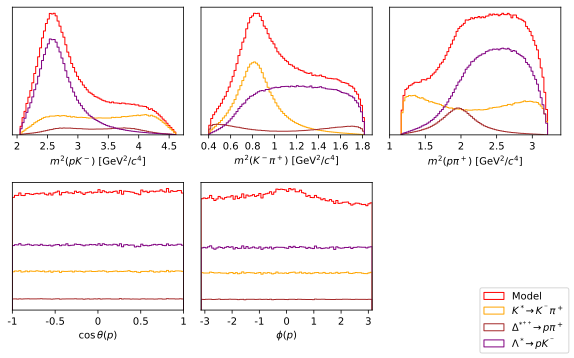

CPU times: user 48.5 s, sys: 3.57 s, total: 52.1 s
Wall time: 41.7 s


In [ ]:
%%time
plot_distributions(standard_model)

## Spin alignment sum

Now, with the spin alignment sum from [ampform#245](https://github.com/ComPWA/ampform/pull/245) inserted:

In [ ]:
builder.align_spin = True
aligned_model = builder.formulate()
set_coefficients(aligned_model)
aligned_model.intensity

PoolSum(Abs(PoolSum(A^01[m_A, lambda_0^01, -lambda_1^01, -lambda_2^01]*WignerD(0, m1, nu_1^01, alpha_1^01, beta_1^01, gamma_1^01)*WignerD(0, m2, lambda_2^01, phi_01, theta_01, 0)*WignerD(0, mu_1^01, lambda_1^01, phi_0^01, theta_0^01, 0)*WignerD(0, nu_1^01, mu_1^01, phi_01, theta_01, 0)*WignerD(1/2, m0, nu_0^01, alpha_0^01, beta_0^01, gamma_0^01)*WignerD(1/2, mu_0^01, lambda_0^01, phi_0^01, theta_0^01, 0)*WignerD(1/2, nu_0^01, mu_0^01, phi_01, theta_01, 0), (lambda_0^01, (-1/2, 1/2)), (mu_0^01, (-1/2, 1/2)), (nu_0^01, (-1/2, 1/2)), (lambda_1^01, (0,)), (mu_1^01, (0,)), (nu_1^01, (0,)), (lambda_2^01, (0,))) + PoolSum(A^02[m_A, lambda_0^02, -lambda_1^02, -lambda_2^02]*WignerD(0, m1, lambda_1^02, phi_02, theta_02, 0)*WignerD(0, m2, nu_2^02, alpha_2^02, beta_2^02, gamma_2^02)*WignerD(0, mu_2^02, lambda_2^02, phi_0^02, theta_0^02, 0)*WignerD(0, nu_2^02, mu_2^02, phi_02, theta_02, 0)*WignerD(1/2, m0, nu_0^02, alpha_0^02, beta_0^02, gamma_0^02)*WignerD(1/2, mu_0^02, lambda_0^02, phi_0^02, thet

:::{warning}

It takes several minutes to lambdify the full expression and expressions for the Wigner rotation angles.

:::

```{autolink-skip}
```

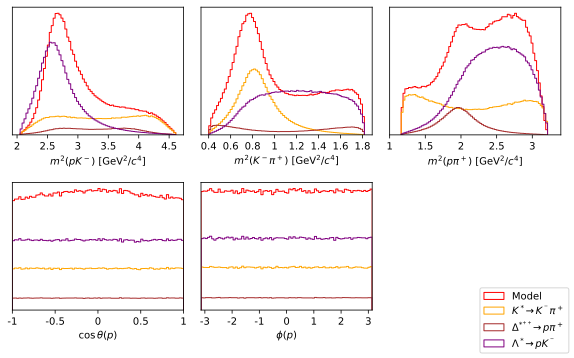

CPU times: user 9min 14s, sys: 17.2 s, total: 9min 31s
Wall time: 8min


In [ ]:
%%time
plot_distributions(aligned_model)

Compare with [Figure 2](https://downloads.hindawi.com/journals/ahep/2020/6674595.pdf#page=9). Note that the distributions differ close to threshold, because the distributions in the paper are produced [with form factors](https://ampform.readthedocs.io/en/0.12.x/api/ampform.dynamics.html#ampform.dynamics.relativistic_breit_wigner_with_ff) and an [energy-dependent width](https://ampform.readthedocs.io/en/0.12.x/api/ampform.dynamics.html#ampform.dynamics.EnergyDependentWidth).